In [1]:
'''In this thesis, 5000 sentences have been used. A lower amount, such as 1000, would give
reasonable similair results'''

number_of_sentences = 5000

# Loading data

In [2]:
from nltk.tree import Tree
import pickle
import os
from ursa import kernel
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import extract_embeddings
import modeling
from BERT import tokenization
import jsonlines
import tensorflow
from skip_thoughts import configuration
from skip_thoughts import encoder_manager
import scipy
import pandas as pd

##  Load data from path

In [ ]:
def retieve_forest_and_source(data_path, forest_folder, source_folder):
    '''Loads the sentence trees and strings from their respective location. The trees in the forest
    and the sentences in the source are alligned by index.'''
    forest_folder_count = 0
    source_folder_count = 0
    for root, dirs, files in os.walk(os.path.join(data_path, forest_folder)):
        forest_folder_count += len(dirs)
    for root, dirs, files in os.walk(os.path.join(data_path, source_folder)):
        source_folder_count += len(dirs)
    source = []
    forest = []
    file_names = []
    for i in range(forest_folder_count):
        folder = str(i)
        if len(folder) == 1:
            folder = "0" + folder
        tree_files = 0
        source_files = 0
        for root, dirs, files in os.walk(os.path.join(data_path, forest_folder, folder)):
            tree_files += len(files)
        for root, dirs, files in os.walk(os.path.join(data_path, source_folder, folder)):
            source_files += len(files)
        assert(tree_files == source_files)
        if folder == "00": 
            for file in range(0, tree_files-1):
                if(len(str(file)) == 1):
                    file = os.path.join(folder, "wsj_" + folder + "0" + str(file))
                    file_names.append(file)
                else:
                    file = os.path.join(folder,"wsj_" + folder + str(file))
                    file_names.append(file)
        else:
            for file in range(0, tree_files-1):
                if(len(str(file)) == 1):
                    file = os.path.join(folder,"wsj_" + folder + "0" + str(file))
                    file_names.append(file)
                else:
                    file = os.path.join(folder,"wsj_" + folder + str(file))
                    file_names.append(file)
    del file_names[0]

    for i in file_names:
        tree_file = open(os.path.join(data_path, forest_folder, i + '.tree'), 'r')
        for sentence in tree_file:
            forest.append(sentence)
        tree_file.close()
        source_file = open(os.path.join(data_path, source_folder, i + '.txt'), 'r')
        #maybe change this to readlines
        for sentence in source_file:
            source.append(sentence)
        source_file.close()
    assert(len(source) == len(forest))
    return(forest, source)


In [60]:
forest, source = retieve_forest_and_source('Penn Treebank\eng_news_txt_tbnk-ptb_revised\data', 'penntree', 'tokenized_source')

forest = forest[0:number_of_sentences]
source = source[0:number_of_sentences]


forest_file = open('forest_file', 'wb')
pickle.dump(forest, forest_file)
forest_file.close()

#retieve_forest_and_source function did not remove the indeces in the string itself
for c, i in enumerate(source):
    source[c] = i.split(">")[1]

source_file = open('source_file', 'wb')
pickle.dump(source, source_file)
source_file.close()

## Load source and forest from pickle

In [103]:
forest_file = open('forest_file','rb')  
source_file = open('source_file','rb') 


string_forest = pickle.load(forest_file)
#converts the parsed sentenced that are stored as string to nltk tree objects.
forest = [Tree.fromstring(tree) for tree in string_forest]
source = pickle.load(source_file)
forest_file.close()
source_file.close()
#check to see if forest and source are aligned.
print(len(forest) == len(source))
print(forest[-1])
print(source[-1])

True
(
  (S
    (PP-TMP (IN At) (NP (DT the) (NN moment)))
    (, ,)
    (NP-SBJ (NNP Nomura))
    (VP
      (VBZ is)
      (NP-PRD
        (NP (DT the) (JJ only) (JJ Japanese) (NN institution))
        (VP
          (VBN authorized)
          (S
            (NP-SBJ (-NONE- *))
            (VP
              (TO to)
              (VP
                (VB act)
                (PP-CLR
                  (IN as)
                  (NP
                    (NP (DT a) (JJ primary) (NN seller))
                    (PP
                      (IN of)
                      (NP
                        (NML (NNP Fannie) (NNP Mae))
                        (NNS instruments)))))))))))
    (. .)))
At the moment , Nomura is the only Japanese institution authorized to act as a primary seller of Fannie Mae instruments .



# Syntax similarity 

Computes the syntax similarity over the sub-trees (ST) and the sub set-trees (SST). To use the SST, set alpha = 1, to use ST, set alpha = 0.

In [ ]:
def create_syntax_DSM(trees, alpha):
    k = kernel.Kernel(alpha = alpha)
    syntax_similarity_matrix = np.empty((len(trees),len(trees)))

    for i in range(0, len(trees)):
        for j in range(i, len(trees)):
            #syntax_similarity_matrix[i,j] = float(k(trees[i], trees[j])) / np.sqrt(float(k(trees[i], trees[i])) * float(k(trees[j], trees[j])))
            #syntax_similarity_matrix[i,j] = float(k.C(trees[i], trees[j])) / np.sqrt(float(k.C(trees[i], trees[i])) * float(k.C(trees[j], trees[j])))
            syntax_similarity_matrix[i,j] = 1 - (k.pairwise(trees[i], trees[j], normalize = True))
            syntax_similarity_matrix[j,i] = syntax_similarity_matrix[i,j]

    return syntax_similarity_matrix

In [ ]:
k = kernel.Kernel()
syntax_DSM = abs(k.pairwise(forest, normalize = True) - 1)

syntax_DSM_file = open('syntax_DSM_file', 'wb')

pickle.dump(syntax_DSM, syntax_DSM_file)
syntax_DSM_file.close()

In [115]:
k = kernel.Kernel(alpha = 0.1)
syntax_DSM_a01 = abs(k.pairwise(forest, normalize = True) - 1)

syntax_DSM_file_a01 = open('syntax_DSM_file_a01', 'wb')

pickle.dump(syntax_DSM_a01, syntax_DSM_file_a01)
syntax_DSM_file_a01.close()

# BERT Embeddings

In [ ]:
def get_max_seq_len(text):
    '''Iterates to a text file with sentences, uses the tokenizer of BERT and checks
    sequence len. Max sequence len is necessary for BERT embeddings input.'''
    #text = open(file, "r")
    tokenizer = tokenization.FullTokenizer(vocab_file=r"uncased_L-12_H-768_A-12/vocab.txt ",\
                                          do_lower_case=True)
    max_sequence_len = 0
    for sentence in text:
        if max_sequence_len < len(tokenizer.tokenize(sentence)) + 2:
            max_sequence_len = len(tokenizer.tokenize(sentence)) + 2
    return max_sequence_len

def jsonl_to_np_matrix(file, token_index, n_sentences, sequence_len = 768):
    '''Extracts the activations from the jsonl file and strores them in a np array 
    with shape(n_sentences, sequence_len. 768 is the output sequence len of BERT_uncased_L-12.)'''
    sentence_embeddings = []
    x = np.empty((n_sentences, sequence_len), dtype = None)
    with jsonlines.open(file) as reader:
        for i, obj in enumerate(reader.iter()):      
            x[i] = np.array(obj["features"][token_index]["layers"][0]["values"])
    return(x)

def cosine_dsim(x):
    '''Computes the DISsimilarity matrix of an array with activations.
    Since the matrix is symmetrical on the diagonal line, half of the 
    values can be copied to the other half.'''
    m = np.zeros((x.shape[0], x.shape[0]))
    for i, p in enumerate(x):
        for j, q in enumerate(x):
            m[i,j] = 1- p.dot(q) / (p.dot(p)**0.5 * q.dot(q)**0.5)
            m[j,i] = m[i,j]
    
    return np.nan_to_num(m)

source_file = open('source_file','rb')
source = pickle.load(source_file)

In [ ]:
#converting source to text file in order to be fed to BERT
file = open("input.txt", "w") 
with open("input.txt", "w") as f:
    for item in source:
        f.write(item)
file.close()

In [ ]:
#creates empty folder if not created yet
if not os.path.exists('BERT_base'):
    os.makedirs('BERT_base')

input_file = r"input.txt"
bert_config_file = r"uncased_L-12_H-768_A-12/bert_config.json" 
max_seq_length = get_max_seq_len(r"input.txt")
init_checkpoint = r"uncased_L-12_H-768_A-12/bert_model.ckpt"
vocab_file = r"uncased_L-12_H-768_A-12/vocab.txt "
lower_case = True
batch_size = 32
use_tpu = False
use_one_hot = False
use_checkpoint = True

'''To go over all the layer individually is inefficient, however
due to memory and cpu constraints, it was not feasible to run BERT once and 
store the activations in one or several files.'''
for layer in range(0,12):
    layer = [layer]
    output_file = r"BERT_base/embeddings_output_layer" + str(layer) + ".jsonl"
    extract_embeddings.embed(input_file, output_file, layer, bert_config_file,\
                             max_seq_length, init_checkpoint, vocab_file, lower_case, batch_size,\
                             use_tpu, use_one_hot, use_checkpoint)

for layer in range(0, 12):
    embedding_first_layer = jsonl_to_np_matrix(r"BERT_base/embeddings_output_layer" + str([layer]) + ".jsonl",\
                                              0, number_of_sentences)
    dsim_matrix = cosine_dsim(embedding_first_layer)
    dsim_file = open(r'BERT_base/dsim_matrix' +str([layer]), 'wb')
    pickle.dump(dsim_matrix, dsim_file)
    dsim_file.close()

In [ ]:
if not os.path.exists('BERT_random'):
    os.makedirs('BERT_random')

input_file = r"input.txt"
bert_config_file = r"uncased_L-12_H-768_A-12/bert_config.json" 
max_seq_length = get_max_seq_len(source)
init_checkpoint = r"uncased_L-12_H-768_A-12/bert_model.ckpt"
vocab_file = r"uncased_L-12_H-768_A-12/vocab.txt "
lower_case = True
batch_size = 32
use_tpu = False
use_one_hot = False
use_checkpoint = False

for layer in range(0,12):
    layer = [layer]
    output_file = r"BERT_random/random_embeddings_output_layer" + str(layer) + ".jsonl"
    extract_embeddings.embed(input_file, output_file, layer , bert_config_file,\
                             max_seq_length, init_checkpoint, vocab_file, lower_case, batch_size,\
                             use_tpu, use_one_hot, use_checkpoint)

for layer in range(0,12):
    embedding_first_layer = jsonl_to_np_matrix(r"BERT_random/random_embeddings_output_layer" + str([layer]) + ".jsonl",\
                                              0, number_of_sentences)
    dsim_matrix = cosine_dsim(embedding_first_layer)
    dsim_file = open(r'BERT_random\random_dsim_matrix' +str([layer]), 'wb')
    pickle.dump(dsim_matrix, dsim_file)
    dsim_file.close()

# Skip-Thought

In [ ]:
data = []

data.extend([line.strip() for line in source])

## Bi-skip

In [ ]:
bi_skt_encoder = encoder_manager.EncoderManager()
bi_skt_encoder.load_model(configuration.model_config(bidirectional_encoder=True),
                   vocabulary_file= r"skipthought\skip_thoughts_bi_2017_02_16\vocab.txt",
                   embedding_matrix_file=r"skipthought\skip_thoughts_bi_2017_02_16\embeddings.npy",
                   checkpoint_path=r"skipthought\skip_thoughts_bi_2017_02_16\model.ckpt-500008")


In [ ]:
bi_skt_embedding = bi_skt_encoder.encode(data)

bi_skt_embedding_file = open('SKT\bi_skt_embedding_file', 'wb')

pickle.dump(bi_skt_embedding, bi_skt_embedding_file)
bi_skt_embedding_file.close()

In [ ]:
bi_skt_dsim_matrix = cosine_dsim(bi_skt_embedding)
dsim_file = open(r'SKT\bi_skt_dsim_matrix', 'wb')
pickle.dump(bi_skt_dsim_matrix, dsim_file)
dsim_file.close()

## Uni-skip

In [ ]:
uni_skt_encoder = encoder_manager.EncoderManager()
uni_skt_encoder.load_model(configuration.model_config(),
                   vocabulary_file= r"skipthought\skip_thoughts_uni_2017_02_02\vocab.txt",
                   embedding_matrix_file=r"skipthought\skip_thoughts_uni_2017_02_02\embeddings.npy",
                   checkpoint_path=r"skipthought\skip_thoughts_uni_2017_02_02\model.ckpt-501424")


In [ ]:
uni_skt_embedding = uni_skt_encoder.encode(data)

uni_skt_embedding_file = open(r'SKT\uni_skt_embedding_file', 'wb')

pickle.dump(uni_skt_embedding, uni_skt_embedding_file)
uni_skt_embedding_file.close()

In [ ]:
uni_skt_dsim_matrix = cosine_dsim(uni_skt_embedding)
dsim_file = open(r'SKT\uni_skt_dsim_matrix', 'wb')
pickle.dump(uni_skt_dsim_matrix, dsim_file)
dsim_file.close()

## Combi-skip

In [ ]:
file = open(r'SKT\uni_skt_embedding_file', 'rb')
uni_skt_embedding = pickle.load(file)
file.close()

file = open(r'SKT\bi_skt_embedding_file', 'rb')
bi_skt_embedding = pickle.load(file)
file.close()

combi_skt_embedding = np.hstack((uni_skt_embedding, bi_skt_embedding))

combi_skt_embedding_file = open(r'SKT\combi_skt_embedding_file', 'wb')

pickle.dump(combi_skt_embedding, combi_skt_embedding_file)
combi_skt_embedding_file.close()

In [ ]:
combi_skt_file = open(r'SKT\combi_skt_embedding_file','rb') 
combi_skt_embedding = pickle.load(combi_skt_file)
source_file.close()

combi_skt_dsim_matrix = cosine_dsim(combi_skt_embedding)
dsim_file = open(r'SKT\combi_skt_dsim_matrix', 'wb')
pickle.dump(combi_skt_dsim_matrix, dsim_file)
dsim_file.close()

# Representational distance

In [3]:
def extract_triu(matrix):
    indices = np.triu_indices(matrix.shape[0], 1)
    return matrix[indices]

def correlate_matrices(matrix1, matrix2, measure):
    if measure == "Pearson":
        return scipy.stats.pearsonr(extract_triu(matrix1), extract_triu(matrix2))
    elif measure == "Spearman":
        return scipy.stats.spearmanr(extract_triu(matrix1), extract_triu(matrix2))


In [ ]:
#correlation between first and last layer of BERT_base
first_layer_file = open(r"BERT_base\dsim_matrix[0]" , 'rb')
matrix1 = pickle.load(first_layer_file)
first_layer_file.close()

last_layer_file = open(r"BERT_base\dsim_matrix[11]", 'rb')
matrix2 = pickle.load(last_layer_file)
last_layer_file.close()

pearson, p_pearson = correlate_matrices(matrix1, matrix2, "Pearson")
spearman, p_spearman = correlate_matrices(matrix1, matrix2, "Spearman")
print(pearson, p_pearson)
print(spearman, p_spearman)

In [ ]:
#correlation between first and last layer of BERT_random
first_layer_file = open(r"BERT_random\random_dsim_matrix[0]" , 'rb')
matrix1 = pickle.load(first_layer_file)
first_layer_file.close()

last_layer_file = open(r"BERT_random\random_dsim_matrix[11]", 'rb')
matrix2 = pickle.load(last_layer_file)
last_layer_file.close()

pearson_r, p_r_pearson = correlate_matrices(matrix1, matrix2, "Pearson")
spearman_r, p_r_spearman = correlate_matrices(matrix1, matrix2, "Spearman")
print(pearson_r, p_r_pearson)
print(spearman_r, p_r_spearman)

In [6]:
def create_correlation_matrix(pickle_names1, pickle_names2, measure, symmetrical = True):
    '''Creates a correlation matrix from data stored in pickles. If symmetrical = True,
    pickle_names1 and pickle_names2 should be identical'''
    correlations = np.zeros((len(pickle_names1), len(pickle_names2)))
    p = np.zeros((len(pickle_names1), len(pickle_names2)))
    for i in range(len(pickle_names1)):
        print(i)
        matrix1_file = open(pickle_names1[i], 'rb')
        matrix1 = pickle.load(matrix1_file)
        matrix1_file.close()
        if symmetrical:
            start = i
        else:
            start = 0
        for j in range(start, len(pickle_names2)):
            matrix2_file = open(pickle_names2[j], 'rb')
            matrix2 = pickle.load(matrix2_file)
            matrix2_file.close()
            correlations[i,j], p[i,j] = correlate_matrices(matrix1, matrix2, measure)
            if symmetrical:
                correlations[j,i], p[j,i] = correlations[i,j], p[i,j]
                
    return correlations, p


In [7]:
#correlating between langauge models and tree kernel
embeddings_pickles = []
for layer in range(12):
    embeddings_pickles.append(r"BERT_base\dsim_matrix" + str([layer]))
for layer in range(12):
    embeddings_pickles.append(r"BERT_random\random_dsim_matrix" + str([layer]))
embeddings_pickles.append(r"SKT\uni_skt_dsim_matrix")
embeddings_pickles.append(r"SKT\bi_skt_dsim_matrix")
embeddings_pickles.append(r"SKT\combi_skt_dsim_matrix")
syntax_pickles = ["syntax_dsm_file", "syntax_dsm_file_a01"]

pearson_correlations, pearson_p = create_correlation_matrix(embeddings_pickles, syntax_pickles, "Pearson", symmetrical = False)
spearman_correlations, spearman_p = create_correlation_matrix(embeddings_pickles, syntax_pickles, "Spearman", symmetrical = False)

pearson_file = open('pearson_file', 'wb')
pickle.dump([pearson_correlations, pearson_p], pearson_file)
pearson_file.close()

spearman_file = open('spearman_file', 'wb')
pickle.dump([spearman_correlations, spearman_p], spearman_file)
spearman_file.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [8]:
#converting correlation matrices to nice pandas dataframes
rows = ["BERT_base layer " + str(i) for i in range(12)] + ["BERT_random layer " + str(i) for i in range(12)] + ["Uni-skip", "Bi-skip", "Combi-skip"]

pearson_file = open('pearson_file', 'rb')
pearson_correlations, pearson_p = pickle.load(pearson_file)
pearson_file.close()

pearson_correlations_df = pd.DataFrame(pearson_correlations)
pearson_correlations_df.columns = ["Pear; a = 1", "Pear; a = 0.1"]
pearson_correlations_df.index = rows

pearson_p_df = pd.DataFrame(pearson_p)
pearson_p_df.columns = ["Pear p; a = 1", "Pear p; a = 0.1"]
pearson_p_df.index = rows

spearman_file = open('spearman_file', 'rb')
spearman_correlations, spearman_p = pickle.load(spearman_file)
spearman_file.close()

spearman_correlations_df = pd.DataFrame(spearman_correlations)
spearman_correlations_df.columns = ["Spear; a = 1", "Spear; a = 0.1"]
spearman_correlations_df.index = rows

spearman_p_df = pd.DataFrame(spearman_p)
spearman_p_df.columns = ["Spear p; a = 1", "Spear p; a = 0.1"]
spearman_p_df.index = rows

df = pd.concat([pearson_correlations_df, pearson_p_df, spearman_correlations_df, spearman_p_df], axis = 1)


In [9]:
df

,Pear; a = 1,Pear; a = 0.1,Pear p; a = 1,Pear p; a = 0.1,Spear; a = 1,Spear; a = 0.1,Spear p; a = 1,Spear p; a = 0.1
BERT_base layer 0,-0.007520,0.429061,9.978953e-156,0.0,-0.216388,0.563763,0.0,0.0
BERT_base layer 1,-0.003211,0.508953,7.307008e-30,0.0,-0.224004,0.554708,0.0,0.0
BERT_base layer 2,-0.007214,0.471193,1.892799e-143,0.0,-0.243478,0.537335,0.0,0.0
BERT_base layer 3,-0.003512,0.414888,2.134067e-35,0.0,-0.255983,0.424788,0.0,0.0
BERT_base layer 4,-0.002822,0.360379,1.934612e-23,0.0,-0.186931,0.356820,0.0,0.0
BERT_base layer 5,-0.003947,0.342710,3.003674e-44,0.0,-0.125128,0.338424,0.0,0.0
BERT_base layer 6,-0.002898,0.326541,1.252694e-24,0.0,-0.116476,0.324054,0.0,0.0
BERT_base layer 7,-0.001512,0.313471,9.088474e-08,0.0,-0.086841,0.306707,0.0,0.0
BERT_base layer 8,-0.000684,0.315376,1.565310e-02,0.0,-0.077609,0.301285,0.0,0.0
BERT_base layer 9,0.002903,0.293388,1.044188e-24,0.0,-0.039024,0.280493,0.0,0.0


# Visualization and descriptives

In [10]:
def pickle_to_plot(reference_RDM_pickle, embeddings_RDMs_pickle, sample_size, plot_name, sub_plot_names, file_name):
    '''Accepts reference representations (in this case syntax) and embedding representations.
    Plots the reference dissimilarity on the y-ax and embeddings dissimilarity on the x-ax and stores the plot.'''
    f, axarr = plt.subplots(1, len(embeddings_RDMs_pickle), sharey=True, figsize=(15,3))
    f.suptitle(plot_name, y=1.15)
    
    file = open(reference_RDM_pickle, 'rb')
    syntax_matrix = pickle.load(file)
    file.close()
    syntax_triangle = extract_triu(syntax_matrix)
    np.random.seed(42)
    sample_indices = np.random.choice(range(len(syntax_triangle)), size=sample_size, replace=False)
    syntax_sample = syntax_triangle[sample_indices]
    for c, i in enumerate(embeddings_RDMs_pickle):
        file = open(i, 'rb')
        embedding_matrix = pickle.load(file)
        file.close()
        axarr[c].scatter(syntax_sample, extract_triu(embedding_matrix)[sample_indices], alpha = 0.5)
        axarr[c].set_xlim(0, 1) 
        axarr[c].set_ylim(0, 1) 
        axarr[c].plot((0, 1), "r--")
        axarr[c].set_title(sub_plot_names[c], y=1.15)
    
    plt.savefig("images/" + file_name + ".png")
    plt.show()
    
    
def pickle_to_matshow(pickle_names, plot_name, sub_plot_names, file_name):
    "Displays the dissimilarity matrices from pickles in color matrices and stores the plots."
    f, axarr = plt.subplots(1, len(pickle_names), sharey=True, figsize=(15,3))
    
    f.suptitle(plot_name, y=1.15)
    for c, i in enumerate(pickle_names):
        file = open(i, 'rb')
        matrix = pickle.load(file)
        file.close()
        axarr[c].matshow(matrix)
        axarr[c].set_title(sub_plot_names[c], y=1.15)
    plt.savefig("images/" + file_name + ".pdf")
    #plt.show()
    plt.imshow(matrix)
    plt.colorbar(extend='both')


    
def summarize(pickle_names):
    '''Prints and stores the descriptives from the upper triangle of a matrix,
    excluding the diagonal.'''
    m = []
    std = []
    for c, i in enumerate(pickle_names):
        file = open(i, 'rb')
        matrix = pickle.load(file)
        file.close()
        triangle = extract_triu(matrix)
        print(pickle_names[c])
        print("Mean:", np.mean(triangle))
        print("Std:", np.std(triangle))
        print()
        m.append(np.mean(triangle))
        std.append(np.std(triangle))
    return(m, std)

if not os.path.exists('images'):
    os.makedirs('images')

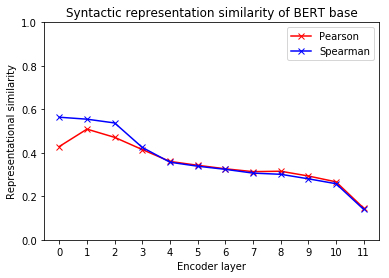

In [24]:
BERT_base_pear = list(df.iloc[0:12, [1]]["Pear; a = 0.1"])
BERT_base_spear = list(df.iloc[0:12, [5]]["Spear; a = 0.1"])

f = plt.figure()

plt.plot(BERT_base_pear, color = "red", marker = "x", label = "Pearson")
plt.plot(BERT_base_spear, color = "blue", marker = "x", label = "Spearman")
plt.xlabel("Encoder layer")
plt.ylabel("Representational similarity")
plt.ylim(0, 1)
plt.xticks(range(12))
plt.legend()
plt.title("Syntactic representation similarity of BERT base")
f.savefig('images/syn_rep.pdf')

plt.show()

## Syntax similarity

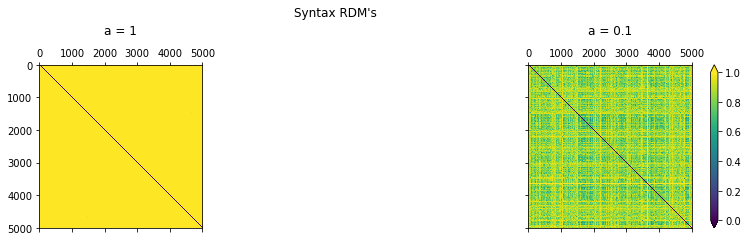

In [11]:
# a = 1
pickle_to_matshow(['syntax_DSM_file', 'syntax_DSM_file_a01'], "Syntax RDM's", ["a = 1", "a = 0.1"], "syntax_RDM_plots")

In [12]:
syntax_mean, syntax_std = summarize(['syntax_DSM_file', 'syntax_DSM_file_a01'])

syntax_DSM_file
Mean: 0.999952271591458
Std: 0.0022658275352761825

syntax_DSM_file_a01
Mean: 0.8457171426851837
Std: 0.08366021245015515



## BERT base

In [ ]:
bert_all_pickles = [r'BERT_base/dsim_matrix' +str([layer]) for layer in range(12)]
bert_pickles_sample = [bert_all_pickles[i] for i in [0, 4, 8, 11]]


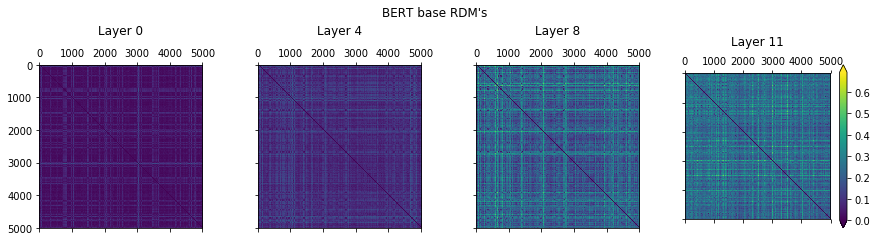

In [14]:
bert_titles = ['Layer ' +str(layer) for layer in [0, 4, 8, 11]]

pickle_to_matshow(bert_pickles_sample, "BERT base RDM's", bert_titles, "BERT_base_RDM_plots")

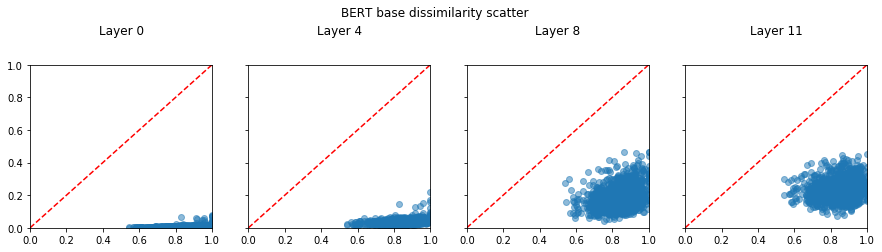

In [15]:
pickle_to_plot("syntax_DSM_file_a01", bert_pickles_sample, int(number_of_sentences/4), "BERT base dissimilarity scatter", bert_titles, "BERT_base_RDM_scatter")

In [17]:
BERT_base_mean, BERT_base_std = summarize(bert_all_pickles)

BERT_base/dsim_matrix[0]
Mean: 0.007141977863951206
Std: 0.0073209191469411124

BERT_base/dsim_matrix[1]
Mean: 0.014749392778447274
Std: 0.008414021882733822

BERT_base/dsim_matrix[2]
Mean: 0.013251011321796962
Std: 0.009351716637761333

BERT_base/dsim_matrix[3]
Mean: 0.025952570023090267
Std: 0.010641744145695959

BERT_base/dsim_matrix[4]
Mean: 0.03706546881105313
Std: 0.015340741700705516

BERT_base/dsim_matrix[5]
Mean: 0.050017914329113254
Std: 0.022111501377118797

BERT_base/dsim_matrix[6]
Mean: 0.11827719365491376
Std: 0.048764381373862034

BERT_base/dsim_matrix[7]
Mean: 0.126304500560758
Std: 0.05513284391366189

BERT_base/dsim_matrix[8]
Mean: 0.18945076925025303
Std: 0.06889074401294944

BERT_base/dsim_matrix[9]
Mean: 0.21866882356213477
Std: 0.06906229066880484

BERT_base/dsim_matrix[10]
Mean: 0.2670970520223305
Std: 0.0685140376852783

BERT_base/dsim_matrix[11]
Mean: 0.24161846344393476
Std: 0.06135993542813213



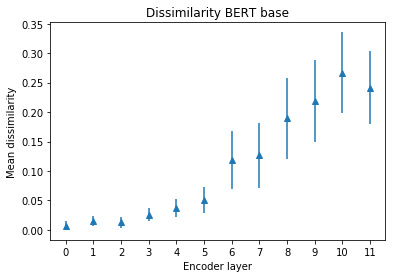

In [26]:
x = range(0,12)
plt.figure()
plt.errorbar(x, BERT_base_mean, BERT_base_std, linestyle='None', marker='^')
plt.title("Dissimilarity BERT base")
plt.xticks(np.arange(12))
plt.xlabel("Encoder layer")
plt.ylabel("Mean dissimilarity")
plt.savefig("images/base.pdf")
plt.show()


## BERT random

In [19]:
bert_r_all_pickles = [r'BERT_random/random_dsim_matrix' +str([layer]) for layer in range(12)]

bert_r_pickles_sample = [bert_r_all_pickles[i] for i in [0, 4, 8, 11]]


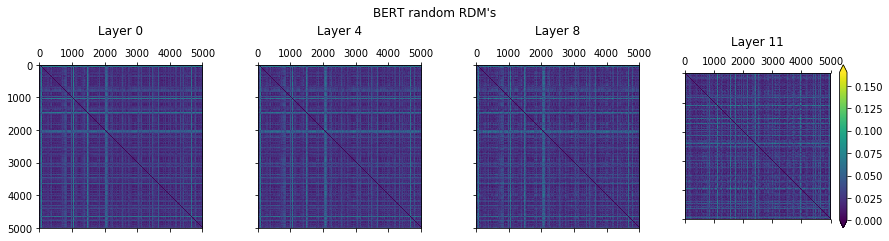

In [20]:
bert_r_titles = ['Layer ' +str(layer) for layer in [0, 4, 8, 11]]

pickle_to_matshow(bert_r_pickles_sample, "BERT random RDM's", bert_r_titles, "BERT_random_RDM_plots")

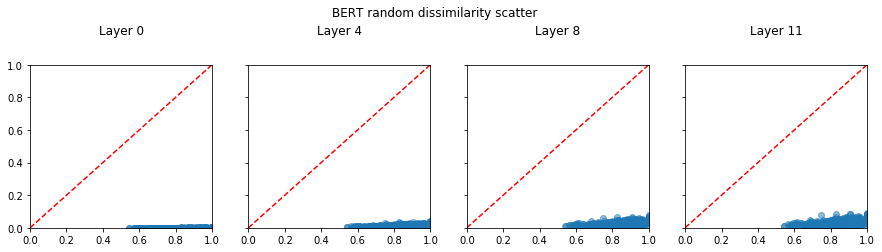

In [21]:
pickle_to_plot("syntax_DSM_file_a01", bert_r_pickles_sample, int(number_of_sentences/4), "BERT random dissimilarity scatter", bert_r_titles, "BERT_random_RDM_scatter")

In [ ]:
BERT_r_mean, BERT_r_std = summarize(bert_r_all_pickles)

In [ ]:
x = range(0,12)
plt.figure()
plt.errorbar(x, BERT_r_mean, BERT_r_std, linestyle='None', marker='^')
plt.title("Dissimilarity BERT random")
plt.xticks(np.arange(12))
plt.xlabel("Encoder layer")
plt.ylabel("Mean dissimilarity")
plt.savefig("images/random")

## Skip-Thought

In [ ]:
skt_pickles = [r"SKT\uni_skt_dsim_matrix", r"SKT\bi_skt_dsim_matrix", r"SKT\combi_skt_dsim_matrix"]
skt_titles = ["Uni-skip", "Bi-skip", "Combi-skip"]

pickle_to_matshow(skt_pickles, "Skip-Thought models", skt_titles, "SKT_RDM_plots")

In [ ]:
pickle_to_plot(r"syntax_DSM_file_a01", skt_pickles, int(number_of_sentences/4), "SKT dissimilarity scatter", skt_titles, "SKT_RDM_scatter")

In [ ]:
SKT_base_mean, SKT_base_std = summarize(skt_pickles)

# Qualitative analysis

In this section, syntactical similair sentences are located for qualitative analyses. A lot of sentences in the Penn Treebank are almost identical with only one word or numeric value different. Therefore, the code below is been run untill the author found a pair of similair sentences that have a low syntactical dissimilarity, but seem to differ in semantics.

In [27]:
def find_similair(m, source):
    x = np.unravel_index(m.argmin(), m.shape)
    
    if source[x[0]] == source[x[1]]:
        m[x[0], x[1]] += 1
        return(find_similair(m, source))
    else:
        m[x[0], x[1]] += 1
        return m, m[x[0], x[1]]-1, source[x[0]], source[x[1]], x

In [28]:
file = open("syntax_DSM_file_a01", 'rb')
matrix = pickle.load(file)
file.close()
for i in range(number_of_sentences):
        matrix[i,i] +=1

source_file = open('source_file','rb') 
source = pickle.load(source_file)
source_file.close()

In [49]:
#run this till you find a satisfactory pair of sentences
matrix, value, sen1, sen2, position = find_similair(matrix, source)
print(sen1, sen2, value, position)

Sales rose to $ 3 million from $ 2.9 million .
 Sales rose to $ 9.8 million from $ 8.9 million .
 0.05858507450240413 (3462, 3464)


In [ ]:
bert_pickles = ['BERT_base/dsim_matrix' +str([layer]) for layer in range(12)]

for i in bert_pickles:
    file = open(i, 'rb')
    matrix = pickle.load(file)
    file.close()
    print(i)
    print(matrix[position])


In [32]:
source[3464]

'Sales rose to $ 9.8 million from $ 8.9 million .\n'

## Correlation matrix

In [ ]:
embeddings_dsim = []
for layer in range(12):
    embeddings_dsim.append(r"BERT_base\dsim_matrix" + str([layer]))
for layer in range(12):
    embeddings_dsim.append(r"BERT_random\random_dsim_matrix" + str([layer]))
embeddings_dsim.append(r"SKT\uni_skt_dsim_matrix")
embeddings_dsim.append(r"SKT\bi_skt_dsim_matrix")
embeddings_dsim.append(r"SKT\combi_skt_dsim_matrix")
embeddings_dsim.append(r"syntax_dsm_file")
embeddings_dsim.append(r"syntax_dsm_file_a01")

In [ ]:
#Create a symmetrical correlation matrix of all the RDM's with respect to the diagonal.

pear_corr_matrix, p_pear_corr_matrix,  = create_correlation_matrix(embeddings_pickles, embeddings_pickles, "Pearson")
spear_corr_matrix, p_spear_corr_matrix = create_correlation_matrix(embeddings_pickles, embeddings_pickles, "Spearman")

file = open('pearson_correlation_matrix', 'wb')
pickle.dump(pear_corr_matrix, file)
file.close()

file = open('spearman_correlation_matrix', 'wb')
pickle.dump(spear_corr_matrix, file)
file.close()

In [ ]:
plt.matshow(pear_corr_matrix)

In [ ]:
plt.matshow(spear_corr_matrix)